In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

We first load the unscaled dataset and show some example lines:

In [2]:
with open('twitter_dataset_unscaled') as fp:
    lines = fp.readlines()

for i in range(3):
    print('Example line {}(1):'.format(i+1), lines[2*i].strip())
    print('Example line {}(2):'.format(i+1), lines[2*i+1])

Example line 1(1): 1.000000000 1040
Example line 1(2): 0.991852821 1040

Example line 2(1): 0.983705642 1013
Example line 2(2): 0.978528431 1013

Example line 3(1): 0.973351219 1089
Example line 3(2): 0.968649552 1089



As we can see from the example lines above, **the normalized values are monotonically decreasing** while **every two lines share the same packet size value** (both can be checked easily).

To get things clearer, we reverse the lines before parsing them:

In [3]:
points = np.array([
    [float(x.strip()) for x in line.split()]
    for line in reversed(lines)
])

Through the example lines above, the plot and the comparison of numbers below, it becomes apparent that the dataset does not represent a CDF/CMF nor a PMF.

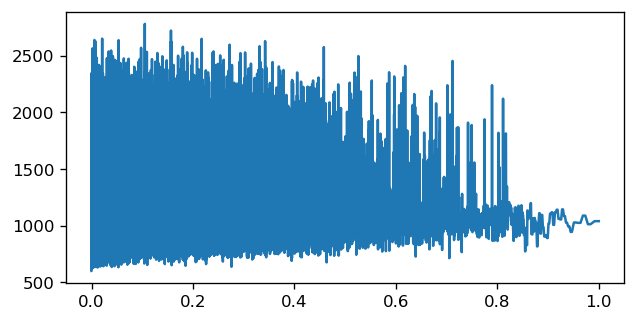

In [4]:
# Visualize the dataset
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
ax.plot(points[:, 0], points[:, 1])
fig.savefig('overview.pdf', dpi=150)

In [5]:
# Compare the number of distinct values and the number of pairs
value_set = set()
for i in range(0, len(lines), 2):
    value_set.add(int(lines[i].split()[-1].strip()))

print('Number of distinct values:', len(value_set))
print('Number of pairs:', len(lines)//2)

Number of distinct values: 1797
Number of pairs: 133717


Since we have found that every two lines share the same packet size value, we would like to visualize them as separate bars:

In [6]:
xs = []
ys = []
widths = []

for i in range(0, len(points), 2):
    assert points[i, 1] == points[i+1, 1]
    ys.append(points[i, 1])
    xs.append(points[i, 0])
    widths.append(points[i+1, 0] - points[i, 0])

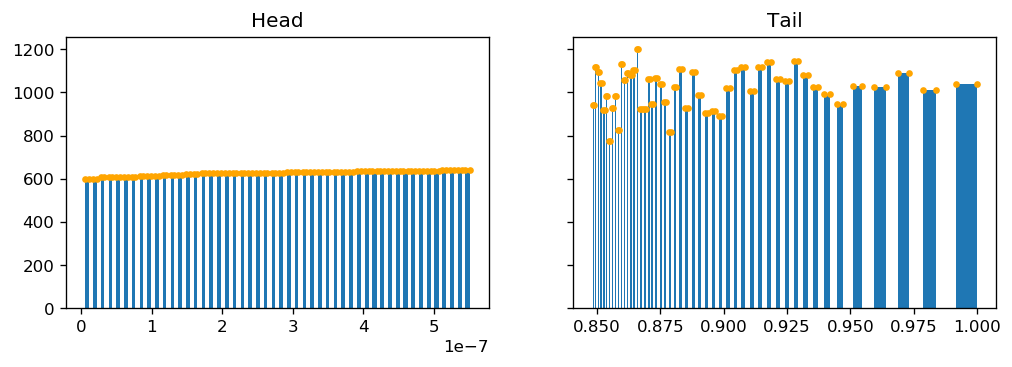

In [7]:
# Visualize the dataset (partially)
head = 50
tail = 50
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 3), dpi=120)

axes[0].bar(xs[:head], ys[:head], widths[:head], align='edge')
axes[0].plot(points[:2*head, 0], points[:2*head, 1], '.', color='orange')
axes[0].set_title('Head')

axes[1].bar(xs[-tail:], ys[-tail:], widths[-tail:], align='edge')
axes[1].plot(points[-2*tail:, 0], points[-2*tail:, 1], '.', color='orange')
axes[1].set_title('Tail')

fig.savefig('bars.pdf', dpi=150)

The loader program in the CloudSuite container `cloudsuite/data-caching:client` uses the dataset to sample packet sizes. More specifically, it generates a random value within `[0, 1)` every time and uses binary search to find the nearest point, whose y value would be used as the sampled packet size.

We assume that the selected point always possesses the smallest horizontal distance to the random value (not necessarily exact, since it depends on how the search algorithm is implemented), and so the dataset can be extended as followes (the spaces between bars are filled):

In [8]:
spaces = []
for i in range(1, len(xs)):
    spaces.append(xs[i]-xs[i-1]-widths[i-1])

# Extended
e_xs = [0.]
e_widths = [None]

for i in range(1, len(xs)-1):
    e_xs.append(xs[i]-spaces[i-1]/2)
    e_widths.append(widths[i]+spaces[i-1]/2+spaces[i]/2)

e_widths[0] = e_xs[1]
e_xs.append(e_xs[-1]+e_widths[-1])
e_widths.append(1.-e_xs[-1])

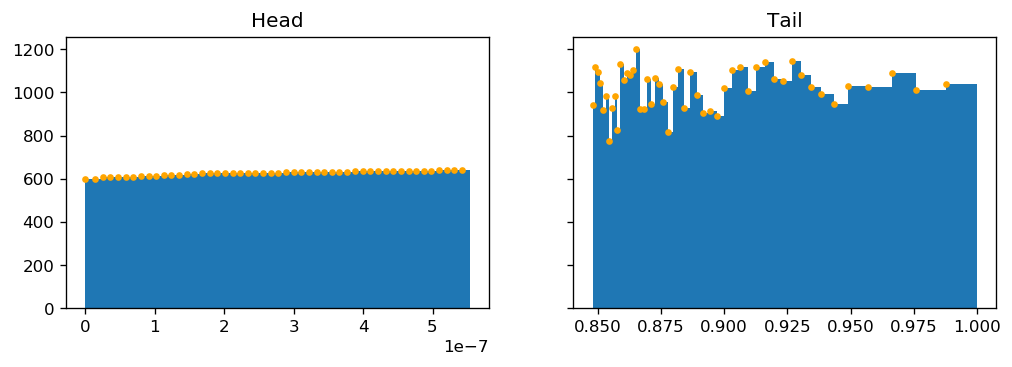

In [9]:
# Visualize the extended dataset (partially)
head = 50
tail = 50
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 3), dpi=120)

axes[0].bar(e_xs[:head], ys[:head], e_widths[:head], align='edge')
axes[0].plot(e_xs[:head], ys[:head], '.', color='orange')
axes[0].set_title('Head')

axes[1].bar(e_xs[-tail:], ys[-tail:], e_widths[-tail:], align='edge')
axes[1].plot(e_xs[-tail:], ys[-tail:], '.', color='orange')
axes[1].set_title('Tail')
fig.savefig('extended.pdf', dpi=150)

And then we sort the extended dataset (sort the bars according to their y values):

In [10]:
y_width_pairs = [(y, width) for y, width in zip(ys, e_widths)]
y_width_pairs.sort(key=lambda x: x[0])

# Re-arranged
r_xs = []
r_ys = []
r_widths = []

cur_x = 0.
for y, width in y_width_pairs:
    r_xs.append(cur_x)
    r_ys.append(y)
    r_widths.append(width)
    cur_x += width

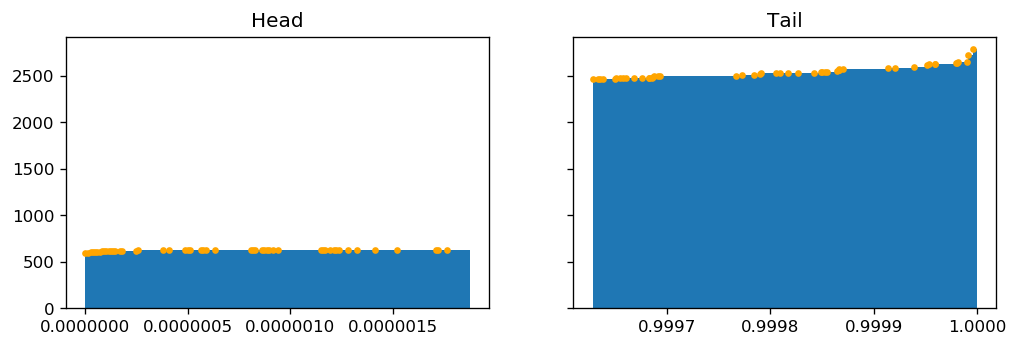

In [11]:
# Visualize the re-arranged dataset (partially)
head = 50
tail = 50
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 3), dpi=120)

axes[0].bar(r_xs[:head], r_ys[:head], r_widths[:head], align='edge')
axes[0].plot(r_xs[:head], r_ys[:head], '.', color='orange')
axes[0].set_title('Head')

axes[1].bar(r_xs[-tail:], r_ys[-tail:], r_widths[-tail:], align='edge')
axes[1].plot(r_xs[-tail:], r_ys[-tail:], '.', color='orange')
axes[1].set_title('Tail')
fig.savefig('re-arranged.pdf', dpi=150)

Swap the axis x and the axis y, we finally get the CDF that the loader program actually samples from:

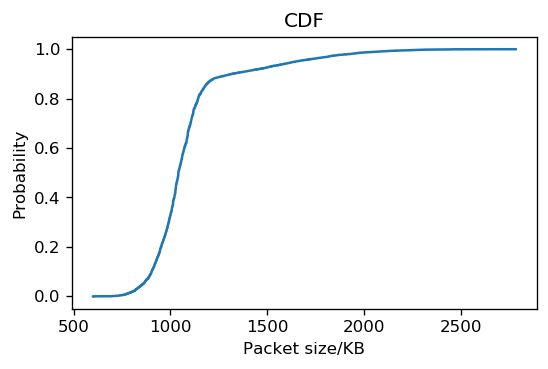

In [12]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=120)

ax.plot(r_ys, r_xs)
ax.set_xlabel('Packet size/KB')
ax.set_ylabel('Probability')
ax.set_title('CDF')
fig.savefig('CDF.pdf', dpi=150)